In [6]:
# Import Modules
import networkx as nx
from pprint import pprint
import operator
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import math

In [8]:
# Load Data
DATASET = "./data"

def loadData(directoryPath):
    """Load the data of all files of the folder given in parameter."""
    files = os.listdir(directoryPath)
    # dictionary wrt to the following format: {topic1:[[network1],[network2]]}
    allGraphsOfEachTopic = {}
    for file in files:
        topic = ""
        if "T16" in file:
            topic = "Data Mining/Association Rules"
        elif "T107" in file:
            topic = "Web Services"
        elif "T131" in file:
            topic = "Bayesian Networks/Belief function"
        elif "T144" in file:
            topic = "Web Mining/Information Fusion"
        elif "T145" in file:
            topic = "Semantic Web/Description Logics"
        elif "T162" in file:
            topic = "Machine Learning"
        elif "T24" in file:
            topic = "Database Systems/XML Data"
        elif "T75" in file:
            topic = "Information Retrieval"
        else:
            topic = "Unknown"

        graphToBuild = nx.Graph()
        graphToBuild.name = topic.replace('/', ' ').replace(' ', '')

        # constant
        VERTEX = 0
        EDGE = 1
        TRIANGLE = 2

        f = open(DATASET+"/"+file)

        # Vertices: Int "String" Int -> NodeID, personName, #papers
        # Edges: Int Int Int -> sourceNodeID, DestNodeID, #coauthoredPapers
        # Triangles: Int,Int,Int,Int -> NodeID1, NodeID2, NodeID3, #coauthoredPapers
        for line in f:
            if "*Vertices" in line:
                typeOfLine = VERTEX
            elif "*Edges" in line:
                typeOfLine = EDGE
            elif "*Triangles" in line:
                typeOfLine = TRIANGLE
            else:
                if typeOfLine == VERTEX:
                    graph_edge_list = [s.replace(' ','') for s in re.split('"', line)]
                    graphToBuild.add_node(graph_edge_list[0], name=graph_edge_list[1], nbpapers=graph_edge_list[2])
                elif typeOfLine == EDGE:
                    graph_edge_list = line.split()
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapers=graph_edge_list[2])
                elif typeOfLine == TRIANGLE:
                    graph_edge_list = line.split(',')
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[1], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])

        if topic in allGraphsOfEachTopic:
            allGraphsOfEachTopic[topic].append(graphToBuild)
        else:
            allGraphsOfEachTopic[topic] = [graphToBuild]

    return allGraphsOfEachTopic

allData = loadData(DATASET)
print("> All data loaded")



> All data loaded


# Implementation of the betweenness centrality measure

In [12]:
def edgesBetweenessCentrality(graph, edge):
    """computes the betweenness centrality of a given edge"""
    centrality = 0
    nodes = list(graph.nodes())

    for vi in range(len(nodes) - 1):
        for vj in range(vi + 1, len(nodes)):
            try:
                shortestPaths = list(nx.all_shortest_paths(graph, source=nodes[vi], target=nodes[vj]))
                nbPathsIncludingEdge = sum(edgeIsInPath([edge[0], edge[1]], path) for path in shortestPaths)
                centrality += nbPathsIncludingEdge / len(shortestPaths)
            except nx.NetworkXNoPath:
                continue
    return centrality

def edgeIsInPath(edge, path):
    """checks if an edge is contained in a path of an undirected graph (the path is a list of nodes)"""
    pathReversed = list(reversed(path))
    n = len(edge)

    if edge in (path[i:i + n] for i in range(len(path) + 1 - n)) or edge in (pathReversed[j:j + n] for j in range(len(pathReversed) + 1 - n)):
        return 1
    else:
        return 0
    
def nodesBetweennessCentrality(graph, node):
    """betweenness centrality of a given node: not used in this project but implemented for fun"""
    centrality = 0
    nodes = list(graph.nodes())

    for vi in range(len(nodes)-1):
        for vj in range(vi+1, len(nodes)):
            if(nodes[vi] == node or nodes[vj] == node):
                continue

            shortestPaths = list(nx.all_shortest_paths(graph, source=nodes[vi], target=nodes[vj]))
            nbPathsIncludingNode = sum(path.count(node) for path in shortestPaths)
            centrality += nbPathsIncludingNode / len(shortestPaths)
    return centrality

# Implementation of visualizations used in Girvan-Newman clustering (see next cell)

In [13]:
def drawGraph(G):
    """draws the given graph and displays the labels of each edge"""
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos)
    plt.show()

def drawGraphs(G, cnt):
    """Draw all different subgraphs on the same picture"""
    test = plt.subplot(4, 3, cnt)
    if (cnt == 1):
        test.title.set_text('Initial state of the graph')
    else:
        test.title.set_text('State of the graph at iteration: {}, number of communities: {}'.format(cnt-1, nx.number_connected_components(G)))
    test.set_yticklabels([])
    test.set_xticklabels([])
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos)
    nx.draw_networkx_edge_labels(G, pos)

def drawColoredGraph(G):
    """# draws a graph where communities are drawn using different colors"""
    test = plt.subplot(4,3,12)
    test.set_yticklabels([])
    test.set_xticklabels([])
    test.title.set_text('Resulting communities ({})'.format(nx.number_connected_components(G)))
    pos = nx.spring_layout(G)
    colors = ['red', 'green', 'orange', 'cyan', 'magenta', 'yellow', 'pink', 'white', 'brown', 'wheat']
    connected_components = nx.connected_component_subgraphs(G)
    for index, sg in enumerate(connected_components):
        nx.draw_networkx(sg, pos = pos, edge_color = colors[index], node_color = colors[index])

# Implementation of Girvan-Newman clustering till 10th iteration level

C:\Users\Jojo\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


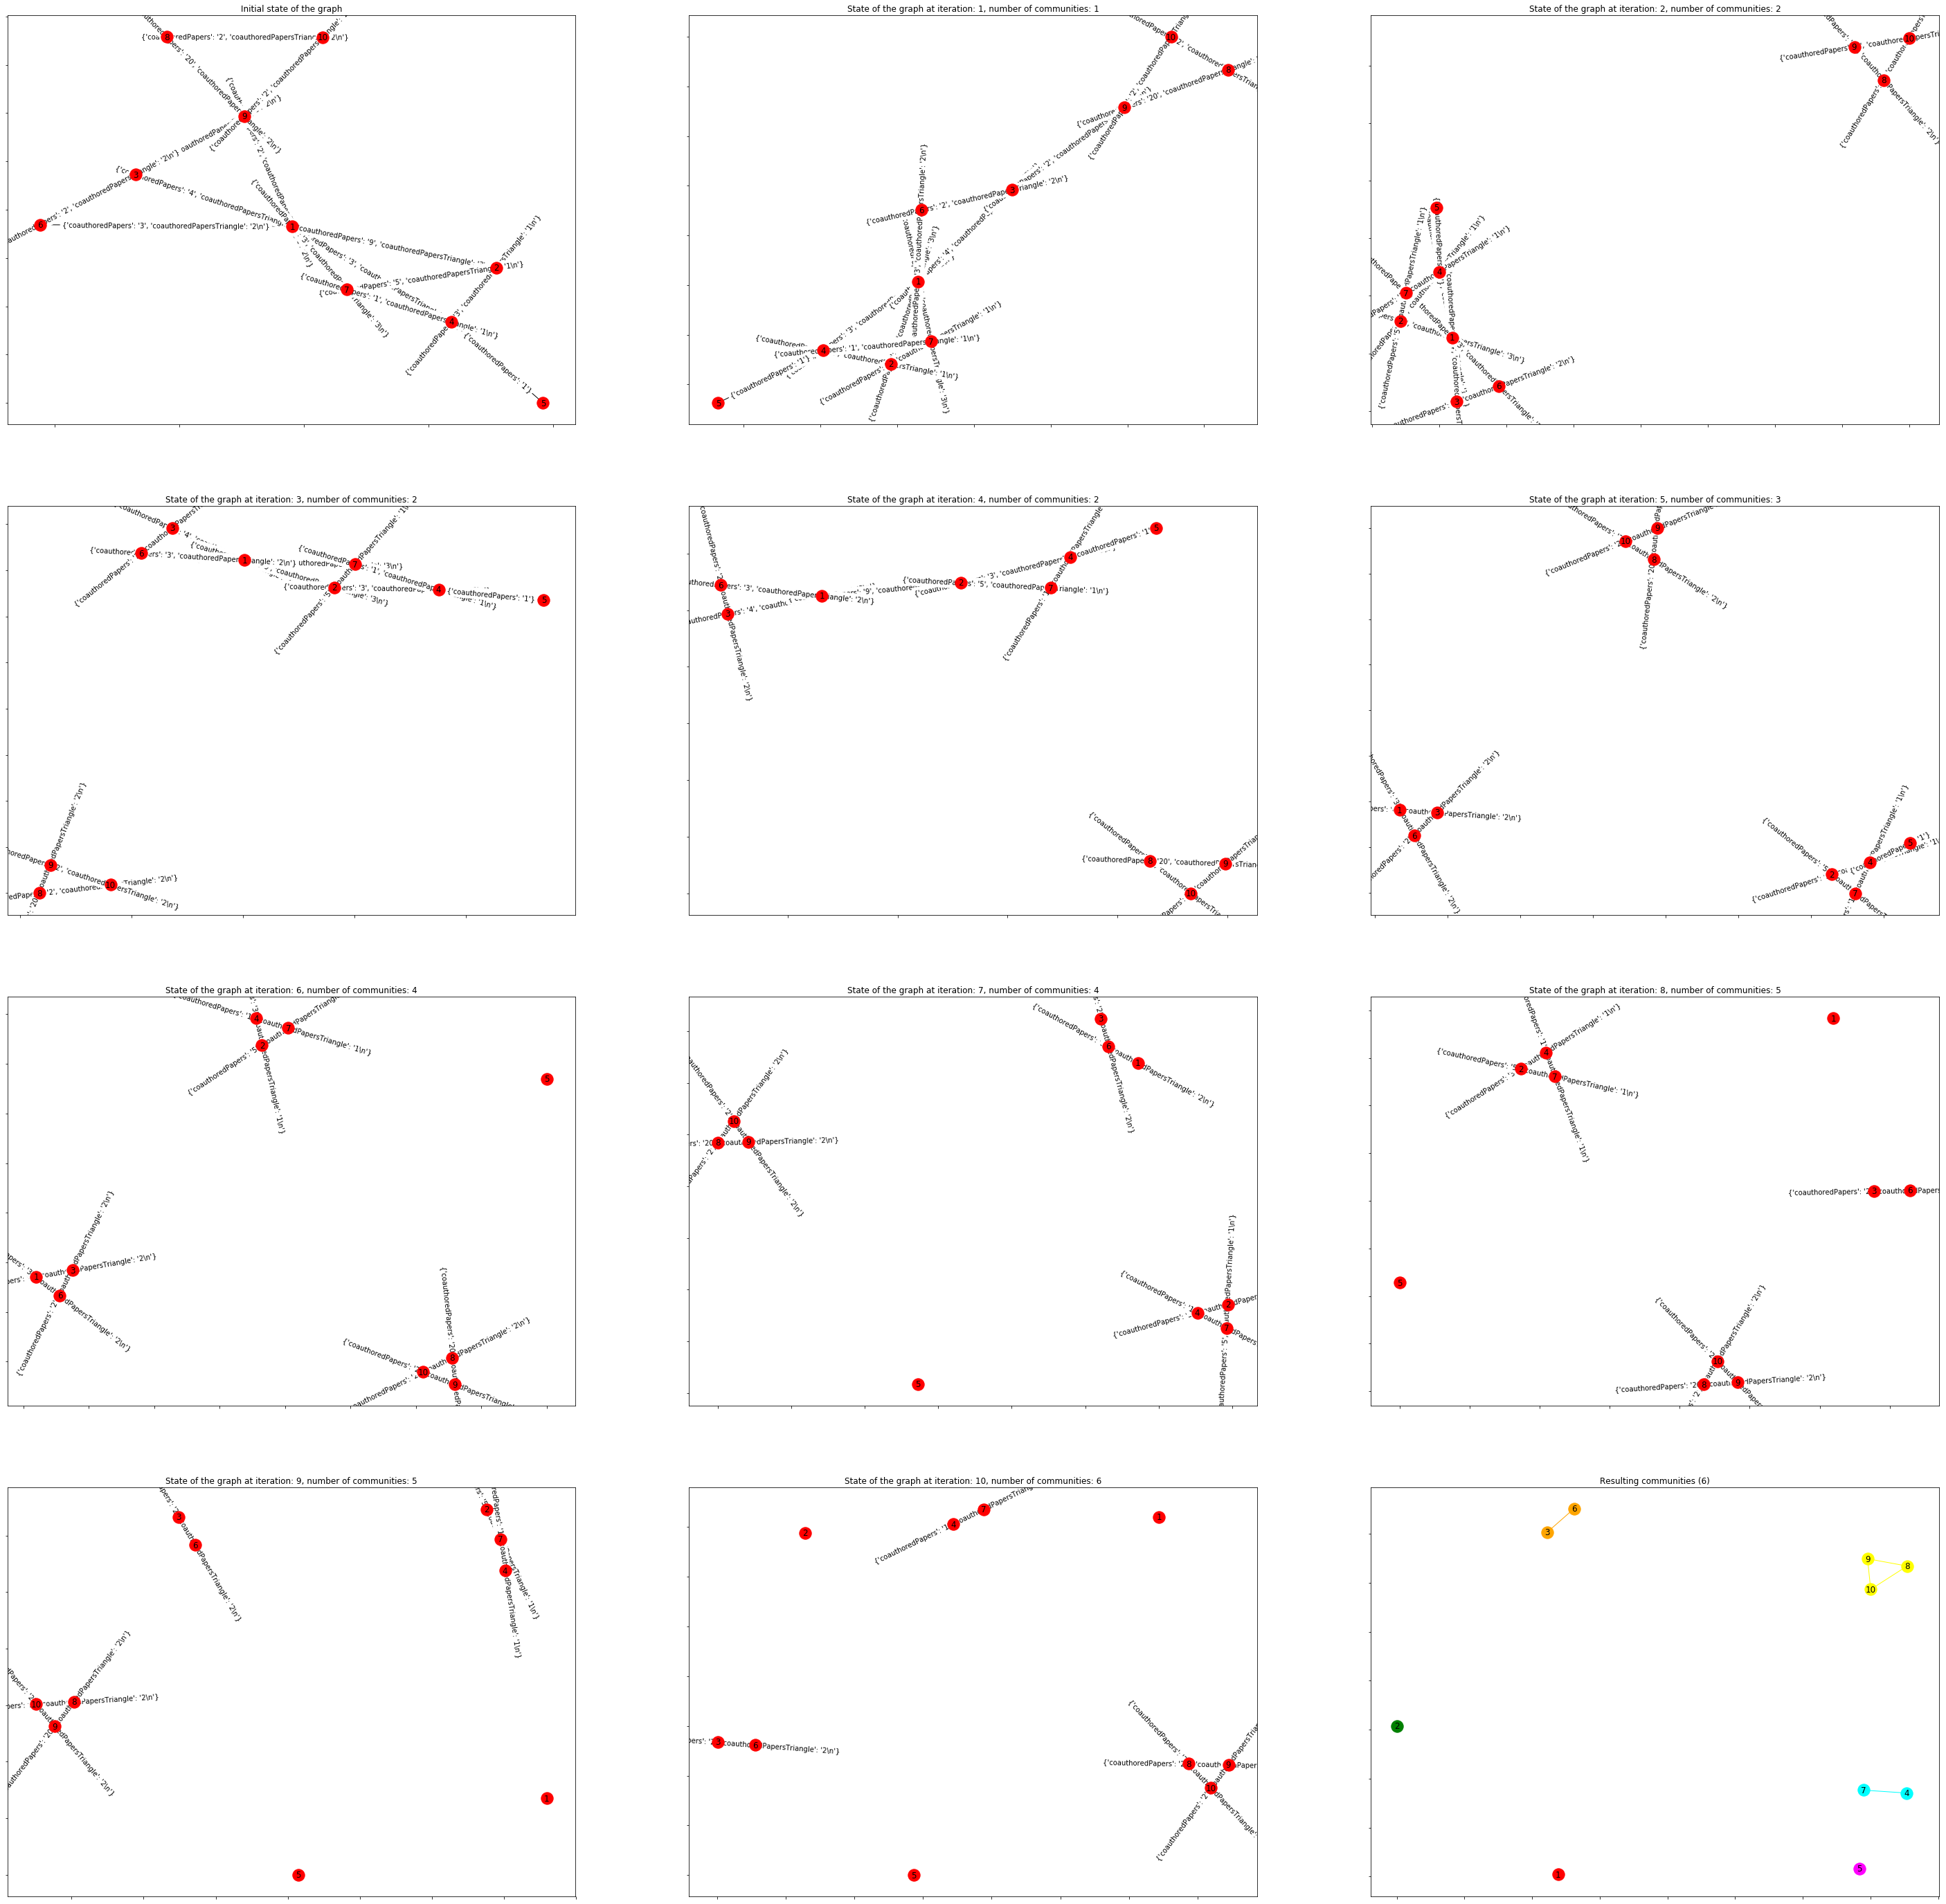

In [14]:
def girvanNewmanClustering(graph, nbIteration):
    """Implementation of the Girvan-Newman clustering algorithm"""
    edges = list(graph.edges)
    fig = plt.figure(figsize=(50, 50))
    drawGraphs(graph, 1)
    cnt = 2

    if len(edges) == 0:
        return "Empty graph"

    while(len(list(graph.edges)) > 0 and nbIteration > 0):
        nbIteration = nbIteration - 1
        highestEdge = ""
        highestScore = -float('inf')
        for edge in edges:
            score = edgesBetweenessCentrality(graph, edge)
            if score > highestScore:
                highestScore = score
                highestEdge = edge

        graph.remove_edge(highestEdge[0], highestEdge[1])
        drawGraphs(graph, cnt)
        cnt += 1

    drawColoredGraph(graph)

    plt.savefig("./Figures/GirvanNewman/{}.png".format(graph.name))
    
    
graph = allData['Semantic Web/Description Logics'][1]
girvanNewmanClustering(graph, 10)

# Implementation of Pagerank algorithm

In [18]:
def pageRankCentrality(graph, alpha, beta):
    # Transposition of matrix
    adjacencyMatrix = nx.to_numpy_matrix(graph, weight='None')
    amTransposed = np.transpose(adjacencyMatrix)

    # Diagonal Matrix
    diagonalMatrix = np.zeros([adjacencyMatrix.shape[0], adjacencyMatrix.shape[1]])
    row, col = np.diag_indices(diagonalMatrix.shape[0])
    # Compute the values that have to be filled into the diagonal
    diagonalMatrix[row, col] = [1 / degree[1] for degree in list(graph.degree())]

    # Identity matrix
    identityMatrix = np.identity(adjacencyMatrix.shape[0])

    # Vector of ones
    ones = np.ones((adjacencyMatrix.shape[0], 1))
    pageRankCentrality = np.dot(beta * np.linalg.inv((identityMatrix - np.dot(alpha * amTransposed, diagonalMatrix))), ones)

    return pageRankCentrality

